In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/pinns

/content/gdrive/My Drive/pinns


In [ ]:
import argparse
import torch
import torch.nn as nn
import data
import utils
import model
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

### 1. Default Setting

1. Domain: 100 x 256 ($x \in [-1,1]$ and $t \in [0,1]$)

2. Collocation points: $N_{ic}=256$ and $N_{f}=25600$

3. Optimizer: Adam with the learning rate of $10^{-3}$


In [ ]:
num_t = 100
num_x = 256
num_epochs = 200000
num_hidden = 4
num_nodes = 128
lr = 1e-3

In [ ]:
# Select a partial differential equation
eq = 'ac' # or 'bg'

### 2. Train Data

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Operation mode: ", device)

Operation mode:  cuda:0


In [ ]:
if eq == 'bg':
    t_data, x_data, u_data, t_data_f, x_data_f = data.bg_generator(num_t, num_x)  
elif eq == 'ac':
    t_data, x_data, u_data, t_data_f, x_data_f = data.ac_generator(num_t, num_x)
else:
    print("There exists no the equation.")
    exit(0)

In [ ]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

### 3. Neural Network

In [ ]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = model.pinn(layer_list).to(device)

### 4. Training Session

In [ ]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 1e-3
bep = 0

In [ ]:
for ep in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        
        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)
        
        if eq == 'bg':
            loss_f = torch.mean(utils.burgers_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'ac':
            loss_f = torch.mean(utils.ac_equation(u_hat_f, variables_f) ** 2)
            
        loss_u = torch.mean((u_hat - u_data) ** 2)
        loss = loss_f + loss_u
        loss.backward() 
        optimizer.step()
        
        l = loss.item()
        loss_graph.append(l)
        if l < ls:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_1d.pth')
            
        if ep % 1000 == 0:
            print(f"Train loss: {l}") 

In [ ]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}") 
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.show()

### 5. Inference Session

In [ ]:
pinn.load_state_dict(torch.load('./'+eq+'_1d.pth'))

<All keys matched successfully>

In [ ]:
if eq == 'bg':       
    t_test, x_test = data.bg_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/burgers_shock.mat')  
    Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact
    
elif eq == 'ac':
    t = np.linspace(0, 1, 201).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, 513)[:-1].reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    t_test = T_star.flatten()[:, None]
    x_test = X_star.flatten()[:, None]
    
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/AC.mat')
    Exact = np.real(data['uu'])
    err = u_pred-Exact

err = np.linalg.norm(err,2)/np.linalg.norm(Exact,2)   
print(f"L2 Relative Error: {err}")

L2 Relative Error: 0.015494434985074365


### 6. Result Figures

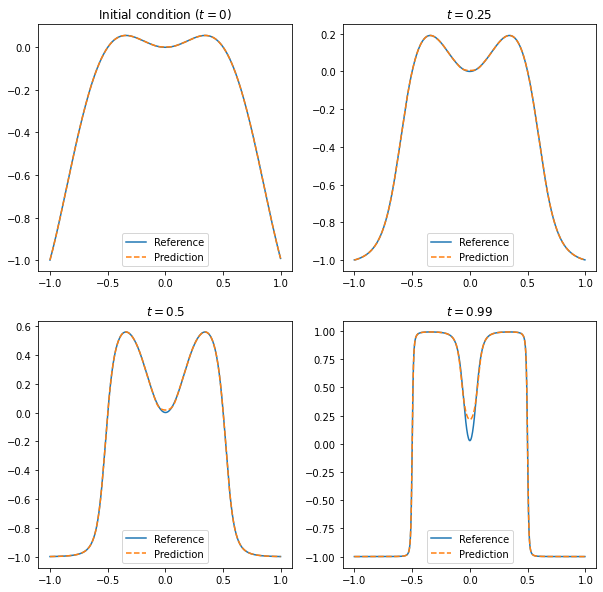

In [ ]:
utils.resplot(x, t, t_data, x_data, Exact, u_pred)

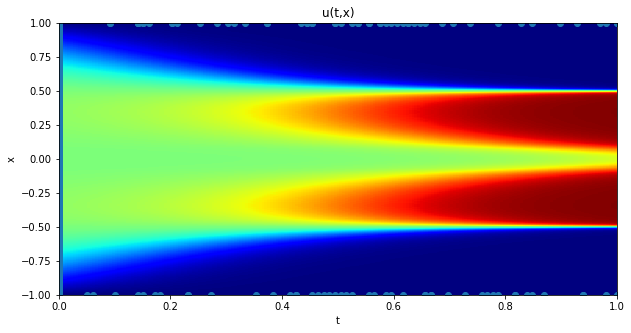

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
plt.clim(-1, 1)
plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()